In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [23]:
#ускорение свободного падения
g=1
#средняя высота
H_= 1
#вязкое трение
b=2
#параметр Кориолиса
f=0
Nx=171
Ny=171
Nt=3000
dt = 0.002
h = np.zeros((Nx,Ny))
u = np.zeros((Nx,Ny))
v = np.zeros((Nx,Ny))
for i in range(Nx):
   for j in range(Ny):
       h[i][j] = (Nx*Ny/2/100 - (Nx/2-i)*(Nx/2-i)/100 - (Nx/2-j)*(Nx/2-j)/100)
for i in range(Nx):
    for j in range(Ny):
        if i>= Nx/4 and j>= Ny/4 and i<=3*Nx/4 and j<= 3*Ny/4:
            h[i][j] = np.abs((i-Nx/4)*(j-Ny/4)*(i-Nx*3/4)*(j-3*Ny/4))/(Nx*Ny)
        else: h[i][j]=0

In [24]:
def periodic_derive_x(h,delta,Nx,Ny,periodic = True):
    hx=np.zeros((Nx,Ny))
    hx[0,:] = (h[1,:] - h[-1,:]) / (2 * delta)
    hx[1:(Nx-1),:] = (h[2:Nx,:] - h[0:(Nx-2),:]) / (2 * delta)
    hx[Nx-1,:] = (h[0,:] - h[Nx-2,:]) / (2 * delta)
    if(periodic==False):
        hx[0,:] = (h[1,:] - h[0,:]) / (delta)
        hx[Nx-1,:] = (h[Nx-1,:] - h[Nx-2,:]) / (delta)
    return hx

def periodic_derive_y(h,delta,Nx,Ny,periodic = True):
    hy=np.zeros((Nx,Ny))
    hy[:,0] = (h[:,1] - h[:,-1]) / (2 * delta)
    hy[:,1:(Ny-1)]= (h[:,2:Ny] - h[:,0:(Ny-2)]) / (2 * delta)
    hy[:,Ny-1] = (h[:,0] - h[:,Ny-2]) / (2 * delta)
    if (periodic==False):
        hy[:,0] = (h[:,1] - h[:,0]) / (delta)
        hy[:,Ny-1] = (h[:,Ny-1] - h[:,Ny-2]) / (delta)
    return hy

def cooler_periodic_derive_x(h,delta,Nx,Ny):
    hx=np.zeros((Nx,Ny))
    hx[0,:] = (h[-2,:] - 8*h[-1,:] + 8* h[1,:] - h[2,:]) / (12 * delta)
    hx[1,:] = (h[-1,:] - 8*h[0,:] + 8* h[2,:] - h[3,:]) / (12 * delta)
    hx[2:(Nx-2),:] = (h[0:(Nx-4),:] - 8*h[1:(Nx-3),:] +8*h[3:(Nx-1),:] - h[4:Nx,:]) / (12 * delta)
    hx[(Nx-2),:] = (h[(Nx-4),:] - 8*h[(Nx-3),:] +8*h[(Nx-1),:] - h[0,:]) / (12 * delta)
    hx[Nx-1,:] = (h[Nx-3,:] - 8*h[Nx-2,:] +8*h[0,:] - h[1,:]) / (12 * delta)
    return hx

def cooler_periodic_derive_y(h,delta,Nx,Ny):
    hy=np.zeros((Nx,Ny))
    hy[:,0] = (h[:,-2] - 8*h[:,-1] + 8* h[:,1] - h[:,2]) / (12 * delta)
    hy[:,1] = (h[:,-1] - 8*h[:,0] + 8* h[:,2] - h[:,3]) / (12 * delta)
    hy[:,2:(Ny-2)] = (h[:,0:(Ny-4)] - 8*h[:,1:(Ny-3)] +8*h[:,3:(Ny-1)] - h[:,4:Nx]) / (12 * delta)
    hy[:,(Ny-2)] = (h[:,(Ny-4)] - 8*h[:,(Ny-3)] +8*h[:,(Nx-1)] - h[:,0]) / (12 * delta)
    hy[:,Ny-1] = (h[:,Ny-3] - 8*h[:,Ny-2] +8*h[:,0] - h[:,1]) / (12 * delta)
    
    return hy

#схема в которой просто при подсчете H_n+1 подставляется u_n+1, v_n+1, а остальное делается явно 

def stupid_scheme_step(u,v,h,Nx,Ny,dt,Nt,g=1,H_=1,b=0.01,f=0,periodic=True):
    dx = 1/Nx
    dy = 1/Ny
    u_new = u.copy()
    v_new = v.copy()
    h_new = h.copy()
    #производные через центральные разности 
    hx = periodic_derive_x(h,dx,Nx,Ny,periodic)
    hy = periodic_derive_y(h,dy,Nx,Ny,periodic)
    ux = periodic_derive_x(u,dx,Nx,Ny,periodic)
    vy = periodic_derive_y(v,dy,Nx,Ny,periodic)
    if(periodic==False):
        hx[0,:] = np.zeros(Ny)
        hy[:,0] = np.zeros(Nx)
        hx[Nx-1,:] = np.zeros(Ny)
        hy[:,Ny-1] = np.zeros(Nx)
    #новые значения скоростей
    u_new = u - dt * (g * hx+b*u-f*v)
    v_new = v - dt * (g * hy+b*v+f*u)
    #новые производные
    u_newx = periodic_derive_x(u_new,dx,Nx,Ny,periodic)
    v_newy = periodic_derive_y(v_new,dy,Nx,Ny,periodic)
    #и наконец новая высота
    h_new = h - H_ * dt * (u_newx + v_newy)
    return u_new,v_new,h_new

def stupid_scheme(u,v,h,Nx,Ny,dt,Nt,g=1,H_=1,b=0.01,f=0,periodic=True):
    h_new = []
    u1,v1,h1 = u.copy(),v.copy(),h.copy()
    h_new.append(h.copy())
    for i in range(Nt):
        u1,v1,h1 = stupid_scheme_step(u1,v1,h1,Nx,Ny,dt,Nt,g,H_,b,f,periodic)
        h_new.append(h1.copy())
    return h_new,u1,v1

#стандартная схема эйлера

def runge_kutta_scheme_step(u,v,h,Nx,Ny,dt,Nt,g=1,H_=1,b=0.01,f=0,periodic = True):
    dx = 1/Nx
    dy = 1/Ny
    ku1 = u.copy()
    kv1 = v.copy()
    kh1 = h.copy()
    #производные через центральные разности 
    hx = periodic_derive_x(h,dx,Nx,Ny,periodic)
    hy = periodic_derive_y(h,dy,Nx,Ny,periodic)
    ux = periodic_derive_x(u,dx,Nx,Ny,periodic)
    vy = periodic_derive_y(v,dy,Nx,Ny,periodic)
    if(periodic==False):
        hx[0,:] = np.zeros(Ny)
        hy[:,0] = np.zeros(Nx)
        hx[Nx-1,:] = np.zeros(Ny)
        hy[:,Ny-1] = np.zeros(Nx)
    #промежуточные значения скоростей
    ku1 = - (g * hx+b*u-f*v)
    kv1 = - (g * hy+b*v+f*u)
    if(periodic==False):
        ku1[0,:] = np.zeros(Ny)
        kv1[:,0] = np.zeros(Nx)
        ku1[Nx-1,:] = np.zeros(Ny)
        kv1[:,Ny-1] = np.zeros(Nx)
    #и наконец промежуточная новая высота
    kh1 = - H_ * (ux + vy)
    return ku1,kv1,kh1


def runge_kutta_scheme(u,v,h,Nx,Ny,dt,Nt,g=1,H_=1,b=0.01,f=0,periodic = True):
    h_new = []
    h_new.append(h.copy())
    u1,v1,h1 = u.copy(),v.copy(),h.copy()
    ku1,kv1,kh1 = u.copy(),v.copy(),h.copy()
    ku1,kv1,kh1 = u.copy(),v.copy(),h.copy()
    ku1,kv1,kh1 = u.copy(),v.copy(),h.copy()
    ku1,kv1,kh1 = u.copy(),v.copy(),h.copy()
    for i in range(Nt):
        ku1,kv1,kh1 = runge_kutta_scheme_step(u1,v1,h1,Nx,Ny,dt,Nt,g,H_,b,f,periodic)
        ku2,kv2,kh2 = runge_kutta_scheme_step(u1 + dt/2*ku1,v1+dt/2*kv1,h1+dt/2*kh1,Nx,Ny,dt,Nt,g,H_,b,f,periodic)
        ku3,kv3,kh3 = runge_kutta_scheme_step(u1 + dt/2*ku2,v1+dt/2*kv2,h1+dt/2*kh2,Nx,Ny,dt,Nt,g,H_,b,f,periodic)
        ku4,kv4,kh4 = runge_kutta_scheme_step(u1 + dt*ku3,v1+dt*kv3,h1+dt*kh3,Nx,Ny,dt,Nt,g,H_,b,f,periodic)
        u1 = u1 + dt/6*(ku1+2*ku2+2*ku3+ku4)
        v1 = v1 + dt/6*(kv1+2*kv2+2*kv3+kv4)
        h1 = h1 + dt/6*(kh1+2*kh2+2*kh3+kh4)
        h_new.append(h1.copy())
    return h_new,u1,v1

In [25]:
H,u1,v1 = runge_kutta_scheme(u,v,h,Nx,Ny,dt,Nt,g,H_,b,f,periodic=True)
Hs,us1,vs1 = stupid_scheme(u,v,h,Nx,Ny,dt,Nt,g,H_,b,f,periodic = True)

<IPython.core.display.Javascript object>


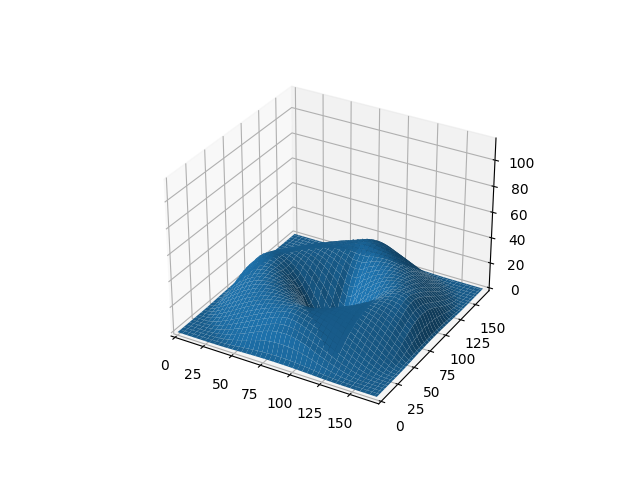

MovieWriter ffmpeg unavailable; using Pillow instead.


In [26]:
from mpl_toolkits.mplot3d import Axes3D
b = range(0,Nx,1)
d = range(0,Ny,1)
%matplotlib notebook
B, D = np.meshgrid(b, d)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(0, Nx-1)
ax.set_ylim(0, Ny-1)
ax.set_zlim(np.min(H[0]), np.max(H[0]))
def animate2(i):
    ax.clear()
    ax.set_xlim(0, Nx-1)
    ax.set_ylim(0, Ny-1)
    ax.set_zlim(0, np.max(H[0]))
    surf = ax.plot_surface(B, D, H[10*i],vmin = np.min(H[0]), vmax = np.max(H[0]),norm=True)
ani = FuncAnimation(fig=fig, func=animate2, interval=200, repeat=False)
ani.save("shallow_water_periodic_gauss_friction.gif")
plt.show()

для начального профиля h(x,y,0) = sin(kx)sin(ky), несложно найти реальное переодическое решение h(t) = sin(kx)sin(ky)cos(wt), на нем и проверялась правильность схемы, аналогично можно посмотреть на реальное решение в коробке h(t) = cos(kx)cos(ky)cos(wt)

In [54]:
#реальное переодичное решение
for i in range(Nx):
    for j in range(Ny):
        h[i][j] = np.sin(i*2*np.pi/(Nx-1))*np.sin(j*2*np.pi/(Ny-1))
H_real=np.zeros((Nt,Nx,Ny))
ht=np.zeros(Nt)
for k in range(Nt):
    ht[k]= np.cos(np.sqrt(H_*g*2)*2*np.pi*k*dt)
for i in range(Nx):
    for j in range(Ny):
        H_real[:,i,j] = np.sin(i*2*np.pi/(Nx-1))*np.sin(j*2*np.pi/(Ny-1))*ht[:]
#реальное решение в коробке
# for i in range(Nx):
#     for j in range(Ny):
#         h[i][j] = np.cos(i*np.pi/(Nx-1))*np.cos(j*np.pi/(Ny-1))
# H_real=np.zeros((Nt,Nx,Ny))
# ht=np.zeros(Nt)
# for k in range(Nt):
#     ht[k]= np.cos(np.sqrt(H_*g*2)*np.pi*k*dt)
# for i in range(Nx):
#     for j in range(Ny):
#         H_real[:,i,j] = np.cos(i*np.pi/(Nx-1))*np.cos(j*np.pi/(Ny-1))*ht[:]

In [55]:
H,u1,v1 = runge_kutta_scheme(u,v,h,Nx,Ny,dt,Nt,g,H_,b,f)
Hs,us1,vs1 = stupid_scheme(u,v,h,Nx,Ny,dt,Nt,g,H_,b,f)

<IPython.core.display.Javascript object>


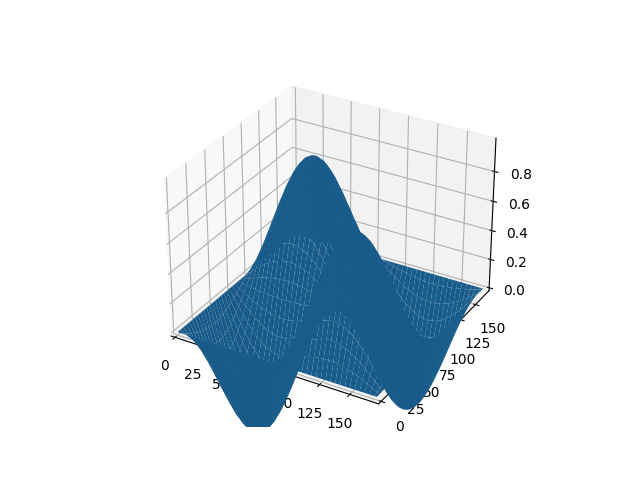

MovieWriter ffmpeg unavailable; using Pillow instead.


In [59]:
from mpl_toolkits.mplot3d import Axes3D
b = range(0,Nx,1)
d = range(0,Ny,1)
%matplotlib notebook
B, D = np.meshgrid(b, d)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(0, Nx-1)
ax.set_ylim(0, Ny-1)
ax.set_zlim(np.min(H[0]), np.max(H[0]))
def animate2(i):
    ax.clear()
    ax.set_xlim(0, Nx-1)
    ax.set_ylim(0, Ny-1)
    ax.set_zlim(0, np.max(H[0]))
    surf = ax.plot_surface(B, D, H_real[10*i],vmin = np.min(H[0]), vmax = np.max(H[0]),norm=True)
ani = FuncAnimation(fig=fig, func=animate2, interval=200, repeat=True)
ani.save("shallow_water_ani_periodic_real.gif")
plt.show()

In [57]:
print(np.max(np.abs(np.array(H[:-1])-np.array(H_real))))

0.04210935103195951
